## 0. Introduction

One simple approach of music recommendation system is to recommend new music to users based on the Genres of the music. One method involves direct analysis of the raw audio information in a given song, scoring the raw data on a variety of metrics. Here the data compiled by a research group known as The Echo Nest is examined for this purpose.

# Table of Contents
1. Preparation
2. Understanding Data
3. Data Processing
4. Feature Engineering
5. Modelling

## 1. Preparation

In [1]:
# Connect goolge drive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Read in track metadata with genre labels
tracks = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Classify Song Genres from Audio Data/datasets/fma-rock-vs-hiphop.csv')

# Read in track metrics with the features
echonest_metrics = pd.read_json('/content/drive/MyDrive/Colab Notebooks/Classify Song Genres from Audio Data/datasets/echonest-metrics.json',precise_float = True)

# Merge the relevant columns of tracks and echonest_metrics
echo_tracks = echonest_metrics.merge(tracks.loc[:,['track_id','genre_top']], how = 'inner')

In [3]:
# Inspect the resultant dataframe

echo_tracks.info()
echo_tracks.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4802 entries, 0 to 4801
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   track_id          4802 non-null   int64  
 1   acousticness      4802 non-null   float64
 2   danceability      4802 non-null   float64
 3   energy            4802 non-null   float64
 4   instrumentalness  4802 non-null   float64
 5   liveness          4802 non-null   float64
 6   speechiness       4802 non-null   float64
 7   tempo             4802 non-null   float64
 8   valence           4802 non-null   float64
 9   genre_top         4802 non-null   object 
dtypes: float64(8), int64(1), object(1)
memory usage: 412.7+ KB


,track_id,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo,valence,genre_top
0,2,0.416675,0.675894,0.634476,0.010628,0.177647,0.159310,165.922,0.576661,Hip-Hop
1,3,0.374408,0.528643,0.817461,0.001851,0.105880,0.461818,126.957,0.269240,Hip-Hop
2,5,0.043567,0.745566,0.701470,0.000697,0.373143,0.124595,100.260,0.621661,Hip-Hop
3,134,0.452217,0.513238,0.560410,0.019443,0.096567,0.525519,114.290,0.894072,Hip-Hop
4,153,0.988306,0.255661,0.979774,0.973006,0.121342,0.051740,90.241,0.034018,Rock


There are no missing values. 'genre_top' is of type 'object', other columns are of type 'numeric'.

## 2. Understanding data

### 2.1 Univariate Analysis

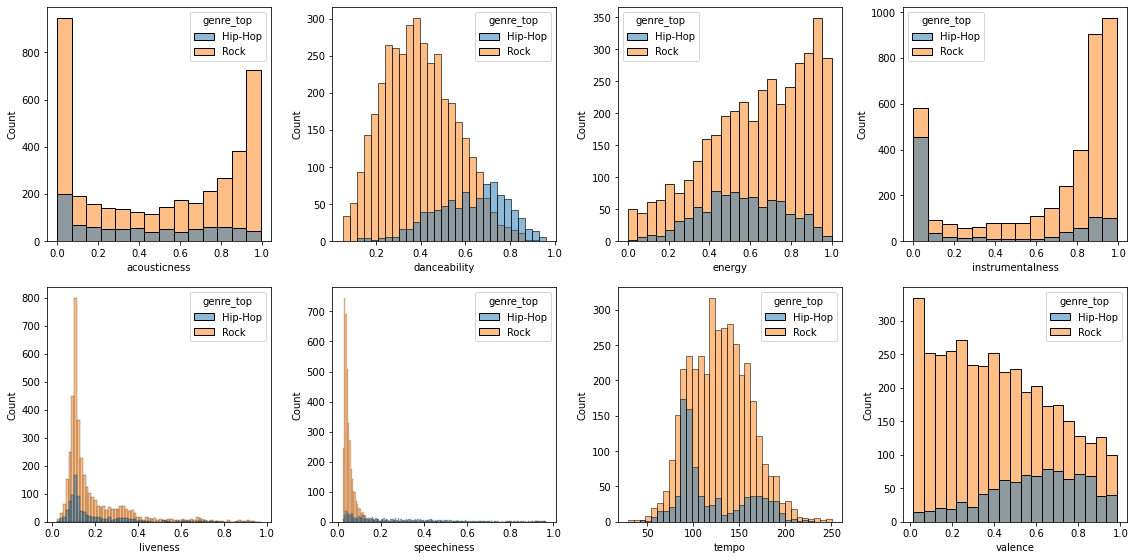

In [4]:
fig = plt.figure(figsize=(16,8))
for index, col in enumerate(echo_tracks.columns[1:-1]):
  plt.subplot(2,4,index+1)
  sns.histplot(x = col, hue = "genre_top", data = echo_tracks)
fig.tight_layout(pad=1.5)

### 2.2 Outliers 

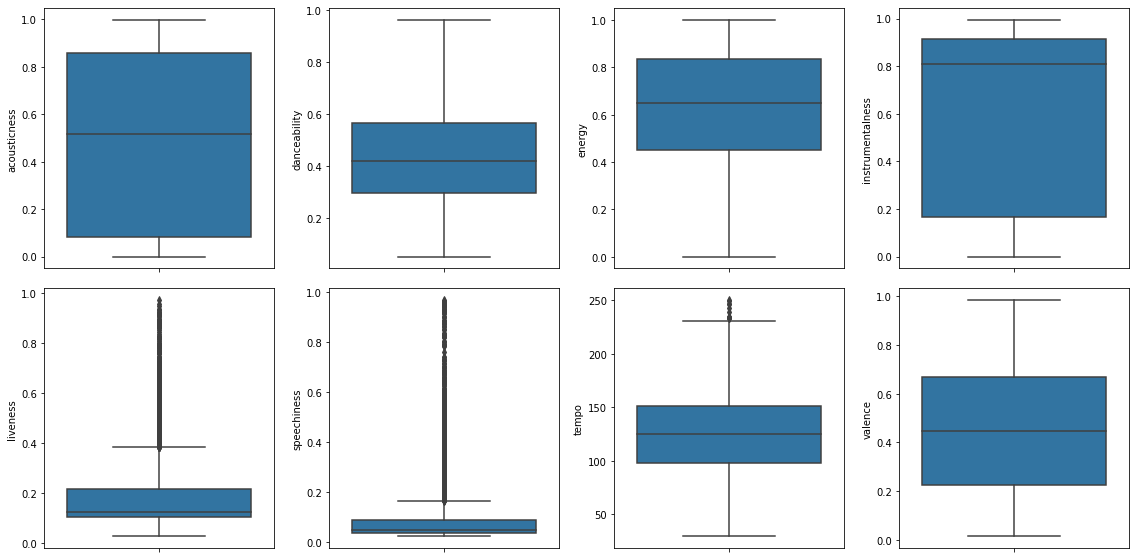

In [5]:
fig = plt.figure(figsize=(16,8))
for index, col in enumerate(echo_tracks.columns[1:-1]):
  plt.subplot(2,4,index+1)
  sns.boxplot(y= col,data = echo_tracks)
fig.tight_layout(pad=1.5)

The distribution of `liveness` and `speechiness` are left-skewed. They should be transferred to normal distribtuion. 

## 2.3 Bi-Variate Analysis

**Correlation Matrix**

In [6]:
# Create a correlation matrix
corr_metrics = echo_tracks.corr(method = 'pearson')
corr_metrics.style.background_gradient()

,track_id,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo,valence
track_id,1.000000,-0.372282,0.049454,0.140703,-0.275623,0.048231,-0.026995,-0.025392,0.010070
acousticness,-0.372282,1.000000,-0.028954,-0.281619,0.194780,-0.019991,0.072204,-0.026310,-0.013841
danceability,0.049454,-0.028954,1.000000,-0.242032,-0.255217,-0.106584,0.276206,-0.242089,0.473165
energy,0.140703,-0.281619,-0.242032,1.000000,0.028238,0.113331,-0.109983,0.195227,0.038603
instrumentalness,-0.275623,0.194780,-0.255217,0.028238,1.000000,-0.091022,-0.366762,0.022215,-0.219967
liveness,0.048231,-0.019991,-0.106584,0.113331,-0.091022,1.000000,0.041173,0.002732,-0.045093
speechiness,-0.026995,0.072204,0.276206,-0.109983,-0.366762,0.041173,1.000000,0.008241,0.149894
tempo,-0.025392,-0.026310,-0.242089,0.195227,0.022215,0.002732,0.008241,1.000000,0.052221
valence,0.010070,-0.013841,0.473165,0.038603,-0.219967,-0.045093,0.149894,0.052221,1.000000


No strong correlation is detected.

## 3. Data processing

### 3.1 Transform categorical to numerical

In [7]:
echo_tracks.head()

,track_id,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo,valence,genre_top
0,2,0.416675,0.675894,0.634476,0.010628,0.177647,0.159310,165.922,0.576661,Hip-Hop
1,3,0.374408,0.528643,0.817461,0.001851,0.105880,0.461818,126.957,0.269240,Hip-Hop
2,5,0.043567,0.745566,0.701470,0.000697,0.373143,0.124595,100.260,0.621661,Hip-Hop
3,134,0.452217,0.513238,0.560410,0.019443,0.096567,0.525519,114.290,0.894072,Hip-Hop
4,153,0.988306,0.255661,0.979774,0.973006,0.121342,0.051740,90.241,0.034018,Rock


In [8]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
echo_tracks.genre_top = le.fit_transform(echo_tracks.genre_top)

### 3.2 Remove outliers

In [9]:
echo_tracks = echo_tracks.drop(echo_tracks[echo_tracks.tempo>230].index)

### 3.3 Log transformation

In [10]:
import numpy as np

echo_tracks.liveness = np.log(echo_tracks.liveness)
echo_tracks.speechiness = np.log(echo_tracks.speechiness)

## 4. Modelling

### 4.1 Split data

In [11]:
X_total = echo_tracks.drop(['genre_top','track_id'], axis = 1)
y_total = echo_tracks.genre_top

from sklearn.model_selection import train_test_split

# divide into train and test 
X,X_test,y,y_test = train_test_split(X_total, y_total, test_size = 0.2, random_state = 42)


### 4.2 Scale of data

In [14]:
from sklearn.preprocessing import StandardScaler

col = ['acousticness','danceability','energy','instrumentalness','liveness','speechiness','tempo','valence']

ss = StandardScaler()

ss.fit(X.loc[:,col])
X = X.copy()
X.loc[:,col] = ss.transform(X.loc[:,col])
X_test = X_test.copy()
X_test.loc[:,col] = ss.transform(X_test.loc[:,col])

### 4.3 Level 0 model

**XGBOOST**

In [24]:
import xgboost 
from sklearn.metrics import classification_report
from sklearn.model_selection import RandomizedSearchCV

xgb = xgboost.XGBClassifier()
param_grid = {'n_estimators': [100, 500, 1000,2000],
               'max_depth': [5, 10, 20, None],
               'learning_rate': [0.3,0.2,0.1, 0.01],
               }

xgb_clf = RandomizedSearchCV(xgb, param_grid, cv = 5, n_jobs = -1)

xgb_search = xgb_clf.fit (X, y)

# tuned parameters 

best_param = xgb_search.best_params_
xgb = xgboost.XGBClassifier(**best_param)

**LightGBM**

In [30]:
import lightgbm 

lgbm = lightgbm.LGBMClassifier()

param_grid = {
    'max_depth' : [2, 5, 8, 10],
    'learning_rate' : [0.001, 0.01, 0.1, 0.2],
    'n_estimators' : [100, 300, 500, 1000, 1500],
    'lambda_l1' : [0.0001, 0.001, 0.01],
    'lambda_l2' : [0, 0.0001, 0.001, 0.01],
    'feature_fraction' : [0.4, 0.6, 0.8],
    'min_child_samples' : [5, 10, 20, 25]
}

lgbm_clf = RandomizedSearchCV(lgbm, param_grid,cv =5, n_jobs= -1)

lgbm_search = lgbm_clf.fit(X,y)

best_param = lgbm_search.best_params_
lgbm = lightgbm.LGBMClassifier(**best_param)

### 4.2 Blending

In [70]:
X_train,X_val,y_train,y_val = train_test_split(X, y, test_size = 0.2, random_state = 42)

# level 0 model 1 
xgb.fit(X_train, y_train)
val_pred1 = pd.DataFrame(xgb.predict(X_val))
test_pred1 = pd.DataFrame(xgb.predict(X_test))

# level 0 model 2 
lgbm.fit(X_train, y_train)
val_pred2 = pd.DataFrame(lgbm.predict(X_val))
test_pred2 = pd.DataFrame(lgbm.predict(X_test))

# concat
df_val = pd.concat([X_val.reset_index(drop=True, inplace=True), val_pred1,val_pred2], axis=1) 
df_test = pd.concat([X_test.reset_index(drop=True, inplace=True), test_pred1,test_pred2], axis=1)

# level 1 model 
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()
model.fit(df_val, y_val)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [71]:
model.score(df_test,y_test)

0.9196242171189979